In [1]:
%pylab inline
from astropy.cosmology import Planck13
from astropy.io import fits
from simqso.sqgrids import *
from simqso import sqbase
from simqso.sqrun import buildSpectraBulk,buildQsoSpectrum,save_spectra,load_spectra,restore_qso_grid
from simqso.sqmodels import BOSS_DR9_PLEpivot,get_BossDr9_model_vars

Populating the interactive namespace from numpy and matplotlib


In [2]:
# cover 1000A to 20um at R=1000
wave = sqbase.fixed_R_dispersion(1000,20e4,1000)

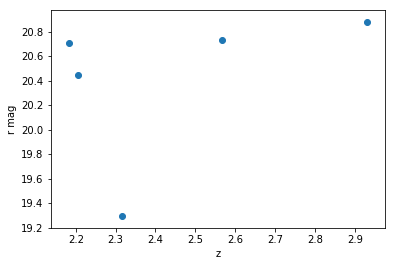

In [13]:
# just make up a few random redshifts between z=2 and z=3, then assign apparent mags according 
# to the BOSS DR9 QLF
nqso = 5
np.random.seed(12345)
zin = 2.0 + np.random.rand(nqso)
kcorr = sqbase.ContinuumKCorr('DECam-r',1450,effWaveBand='SDSS-r')
qsos = generateQlfPoints(BOSS_DR9_PLEpivot(cosmo=Planck13),
                         (17,22),(2.0,3.0),
                         kcorr=kcorr,zin=zin,
                         qlfseed=12345,gridseed=67890)
scatter(qsos.z,qsos.appMag)
xlabel('z')
ylabel('r mag');

In [5]:
# add the fiducial quasar SED model from BOSS DR9
# need to set forestseed if the forest transmission sightlines are to be reproducible
sedVars = get_BossDr9_model_vars(qsos,wave,0,forestseed=192837465,verbose=1)
qsos.addVars(sedVars)

Generating 5 sightlines


In [6]:
# define photometry in DECam and WISE systems
qsos.loadPhotoMap([('DECam','DECaLS'),('WISE','AllWISE')])

In [7]:
# ready to generate spectra. iteration is necessary to converge on the per-object k-correction,
# after two steps the maximum error on the absolute mags is <<1%
_,spectra = buildSpectraBulk(wave,qsos,saveSpectra=True,maxIter=3,verbose=10)

simulating  5  quasar spectra
units are  flux
buildSpectra iteration  1  out of  3
--> delta mag mean = -0.1805940, rms = 0.0932394, |max| = 0.2664833
buildSpectra iteration  2  out of  3
--> delta mag mean = -0.0117782, rms = 0.0149088, |max| = 0.0407848
buildSpectra iteration  3  out of  3
--> delta mag mean = -0.0003638, rms = 0.0006547, |max| = 0.0016694


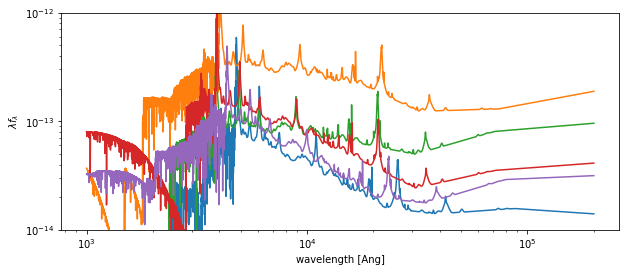

In [8]:
figure(figsize=(10,4))
plot(wave,(wave*spectra).transpose())
xscale('log')
yscale('log')
xlabel('wavelength [Ang]')
ylabel(r'$\lambda{f}_\lambda}$')
ylim(1e-14,1e-12);

In [9]:
# the parameter values for each spectrum
qsos.data

<Table length=5>
  absMag     appMag      z     ...       synMag [5]            synFlux [5]      
 float32    float32   float32  ...        float32                float32        
---------- --------- --------- ... ---------------------- ----------------------
-24.311958  20.87938  2.929616 ...  20.850298 .. 20.46095  4.569625 .. 6.5406303
-25.419514 19.292582 2.3163755 ...  19.323055 .. 18.17416 18.654253 .. 53.744743
-23.850546  20.71041 2.1839187 ... 20.780043 .. 18.934736  4.875095 .. 26.675053
-24.353584 20.442558 2.2045603 ... 20.354904 .. 19.772062  7.211717 .. 12.336015
-24.366837 20.735466  2.567725 ...   20.666018 .. 20.1213   5.4149346 .. 8.94293

In [9]:
# save the simulation meta-data to a file
qsos.write('quickspeclib_meta',extname='quickspec',overwrite=True)

In [10]:
ff = fits.open('quickspeclib_meta.fits')
ff.info()

Filename: quickspeclib_meta.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  QUICKSPEC     1 BinTableHDU     66   10R x 8C   [E, E, E, 5E, 186E, J, 5E, 5E]   


In [11]:
# save the spectra to a fits bin table
save_spectra(wave,spectra,'quickspeclib')

In [12]:
# restore the spectra
wave,spec = load_spectra('quickspeclib')

In [13]:
# restore the simulation meta-data into a QsoSimObjects
qsos_restore = restore_qso_grid('quickspeclib_meta',wave,extname='quickspec')

In [14]:
# rebuild a single quasar spectrum
spec0 = buildQsoSpectrum(wave,qsos_restore.cosmo,
                         qsos_restore.getVars(SpectralFeatureVar),
                         qsos_restore.data[0])

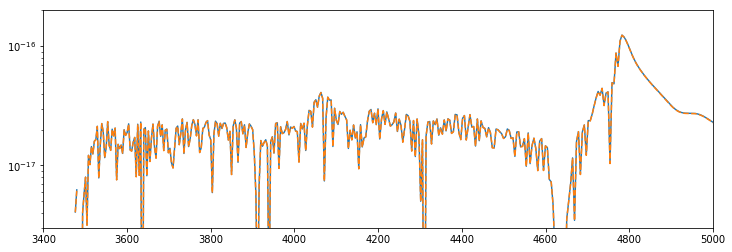

In [15]:
# plot the original and restored spectra for comparison
figure(figsize=(12,4))
plot(wave,spectra[0],lw=1.4)
plot(wave,spec0.f_lambda,ls='--')
yscale('log')
ylim(3e-18,2e-16)
xlim(3400,5000);#1e4);

In [16]:
# restore another spectrum
spec1 = buildQsoSpectrum(wave,qsos_restore.cosmo,
                         qsos_restore.getVars(SpectralFeatureVar),
                         qsos_restore.data[1])

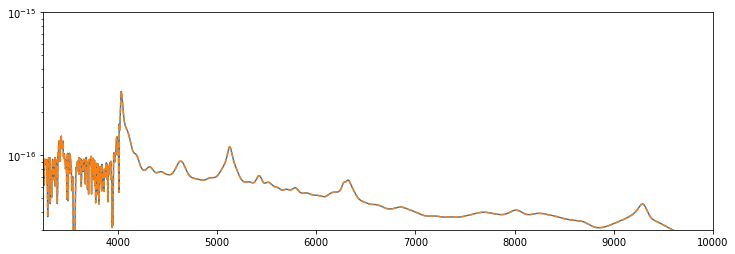

In [17]:
# and plot the comparison again
figure(figsize=(12,4))
plot(wave,spectra[1],lw=1.4)
plot(wave,spec1.f_lambda,ls='--')
yscale('log')
ylim(3e-17,10e-16)
xlim(3250,1e4);

In [18]:
# rebuild all of the spectra
_,allspec = buildSpectraBulk(wave,qsos_restore)

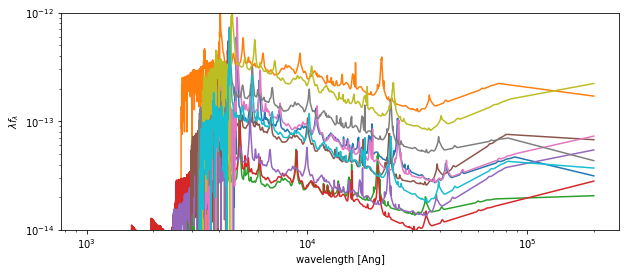

In [19]:
figure(figsize=(10,4))
plot(wave,(wave*spectra).transpose())
xscale('log')
yscale('log')
xlabel('wavelength [Ang]')
ylabel(r'$\lambda{f}_\lambda}$')
ylim(1e-14,1e-12);